# Worksheet 10: PCA & SVD

Problem 5:

Begin by leveraging previous work:

In [6]:
# Imported Code from Professor:
from struct import unpack
import numpy as np
import pandas as pd
import matplotlib.pylab as plt 

def loadmnist(imagefile, labelfile):

    # Open the images with gzip in read binary mode
    images = open(imagefile, 'rb')
    labels = open(labelfile, 'rb')

    # Get metadata for images
    images.read(4)  # skip the magic_number
    number_of_images = images.read(4)
    number_of_images = unpack('>I', number_of_images)[0]
    rows = images.read(4)
    rows = unpack('>I', rows)[0]
    cols = images.read(4)
    cols = unpack('>I', cols)[0]

    # Get metadata for labels
    labels.read(4)
    N = labels.read(4)
    N = unpack('>I', N)[0]

    # Get data
    x = np.zeros((N, rows*cols), dtype=np.uint8)  # Initialize numpy array
    y = np.zeros(N, dtype=np.uint8)  # Initialize numpy array
    for i in range(N):
        for j in range(rows*cols):
            tmp_pixel = images.read(1)  # Just a single byte
            tmp_pixel = unpack('>B', tmp_pixel)[0]
            x[i][j] = tmp_pixel
        tmp_label = labels.read(1)
        y[i] = unpack('>B', tmp_label)[0]

    images.close()
    labels.close()
    return (x, y)

def displaychar(image):
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()

In [101]:
# Train
train_images = "/Users/kkannapp/Documents/DSE/DSE210-homework/day_3/train-images-idx3-ubyte"
train_labels = "/Users/kkannapp/Documents/DSE/DSE210-homework/day_3/train-labels-idx1-ubyte"
# Test
test_images = "/Users/kkannapp/Documents/DSE/DSE210-homework/day_3/t10k-images-idx3-ubyte"
test_labels = "/Users/kkannapp/Documents/DSE/DSE210-homework/day_3/t10k-labels-idx1-ubyte"

train_x,train_y = loadmnist(train_images,train_labels)
test_x,test_y = loadmnist(test_images,test_labels)

In [102]:
# Preview the data
train_x[0],train_y[0] # First entry is a 28 x 28 matrix of pixels, and is classified as a 5

(array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,  18,  18,
        126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,  30,  36

In [103]:
# Part a)
# Leverage covariance matrix to gather eigenvalues & eigenvectors
cov=np.cov(train_x.T)
lamda, evectors = np.linalg.eig(cov)
lamda = np.float64(lamda)
evectors = np.float64(evectors)
total_var = sum(lamda)

/Users/kkannapp/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """
/Users/kkannapp/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [104]:
# Provides the sum of lost variance
sum(lamda[25::])

1056647.6637139525

In [105]:
# Let us compute a fraction of lost variance, for each value of k defined by F(k):
def F(k):
    lost_variance = sum(lamda[k+1::])
    return lost_variance/total_var

In [106]:
k_var = [(i, F(i)) for i in [200, 150, 100, 50, 25]]

k_lost_var = pd.DataFrame(data = k_var, columns = ['k value', 'Variance Lost'])
k_lost_var

,k value,Variance Lost
0,200,0.033271
1,150,0.051177
2,100,0.084387
3,50,0.172163
4,25,0.299802


In [144]:
# Part b)
# Apply PCA formula to re-generate images, calculate class probabilities

class PCA_fx(object):
    
    def __init__(self,train_x,train_y):
        self.train_x = train_x
        self.train_y = train_y
        self.dict={}
        self.dict = {num:{} for num in range(10)}

    def F(self, k):
        lost_variance = sum(self.lamda[k+1::])
        return lost_variance/self.total_var
    
    def reshape_proj(self, k, image, image_id):
        U_matrix = self.evectors[:,:k+1]
        transform_U = np.dot(U_matrix,U_matrix.T)
        image = image.T
        X = np.dot(transform_U,image).T[image_id]
        X = X.reshape(28,28)
        return X
    
    def show_digit(self,X,k):
        plt.imshow(X, cmap=plt.cm.gray) 
        plt.title('%i' % k, fontsize = 10)
        plt.axis('off')
    
    def computation(self):
        for num in range(10):
            x_train = []
            y_train = []
            for i, image in enumerate(self.train_x):
                if train_y[i] == num:
                    x_train.append(image)
                    y_train.append(num)
            x_train = np.array(x_train)
            cov = np.cov(x_train.T)
            lamda, evectors = np.linalg.eig(cov)
            self.lamda = np.float64(lamda)
            self.evectors = np.float64(evectors)
            self.total_var = np.sum(self.lamda)
            index = 0
            plt.figure(figsize=(15,5))
            for k in [784, 200, 150, 100, 50, 25]:
                self.dict[num][k]=self.F(k)
                image_reduced = self.reshape_proj(k, x_train[:10], 0)
                index += 1
                plt.subplot(1, 6, index)
                self.show_digit(image_reduced, k)
            plt.show();

/Users/kkannapp/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/kkannapp/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part


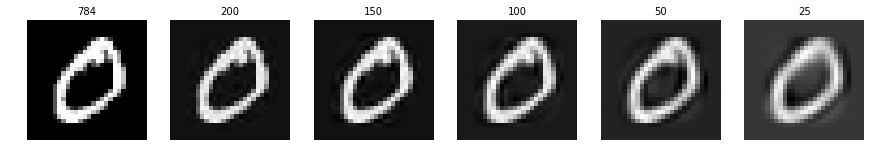

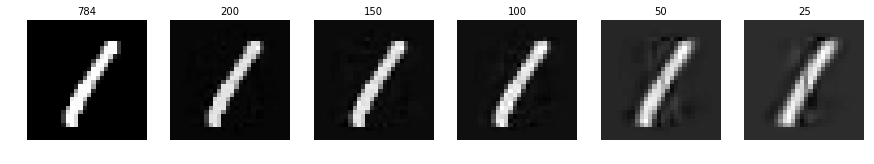

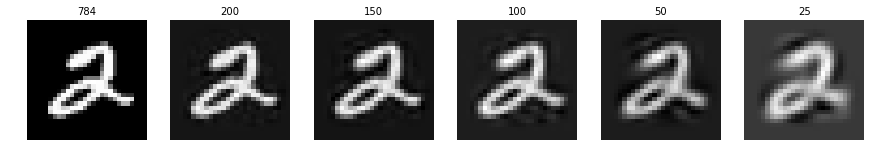

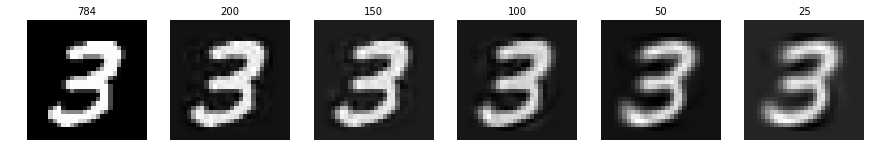

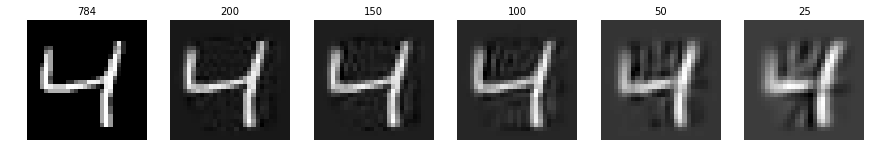

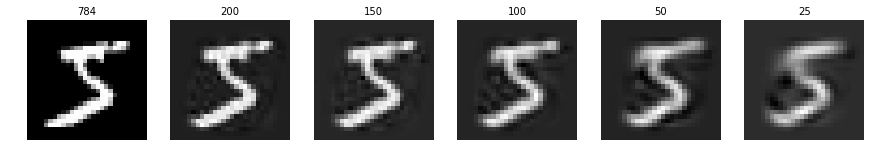

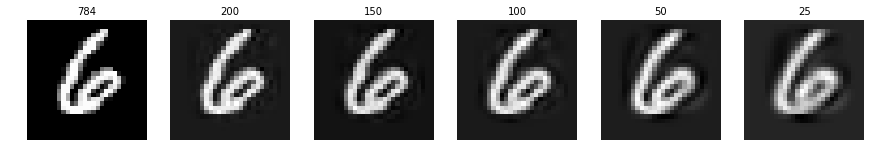

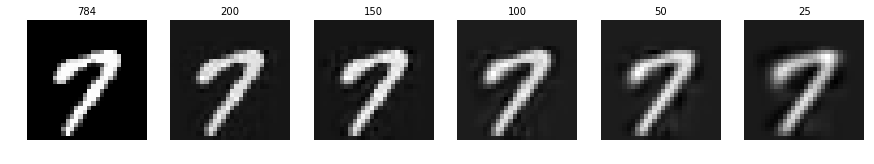

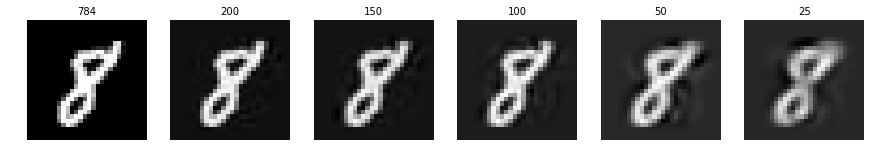

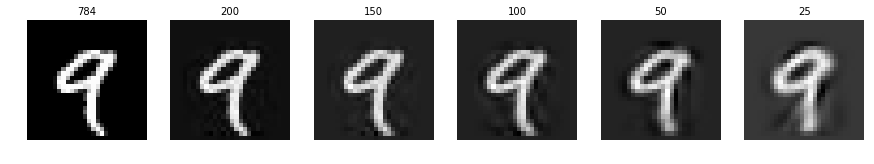

In [145]:
PCA_Class = PCA_fx(train_x, train_y)
PCA_Class.computation()

In [146]:
lost_var_table = pd.DataFrame(PCA_Class.dict)
lost_var_table

,0,1,2,3,4,5,6,7,8,9
25,0.201817,0.127616,0.276346,0.268917,0.246501,0.256309,0.216404,0.216041,0.291628,0.218670
50,0.117534,0.071766,0.158965,0.156145,0.145469,0.147014,0.120032,0.126723,0.164755,0.121179
100,0.058764,0.030534,0.077597,0.075243,0.072825,0.070057,0.057224,0.062837,0.076202,0.056898
150,0.034165,0.014634,0.045578,0.043139,0.042213,0.039591,0.032374,0.035918,0.042682,0.030738
200,0.020834,0.006765,0.028082,0.026002,0.025398,0.023609,0.018940,0.021194,0.024901,0.016958
784,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Based on this table, I would expect 1 to be the digit most amenable to dimensionality reduction. Intuitively, this makes the most sense.